In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# This tutorial explains the basic pipeline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [2]:
import agentnet.experiments.boolean_reasoning as experiment
print(experiment.__doc__)


Boolean reasoning is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

Th

In [3]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation contains three parts:
 * Memory layer(s)
   * in this case, a single one-step RNN
   * may be any amount of recurrent layers [GRU/LSTM, LTM, custom or none at all]
   * you have to create a dict {new recurrent state : previous state} (see next tabs)
   
 * Policy estimation layers
   * In this case, predicted Qvalues for all actions (via DenseLayer)
   * Whatever is required for agent to pick action
   * Can be any lasagne network
   
 * Resolver - acton picker
   * in this case, the resolver has epsilon-greedy policy

In [4]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer

from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory.rnn import RNNCell
from agentnet.agent import Agent

In [5]:

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_shapes)

observation_layer = InputLayer(observation_size,name="obs_input")
prev_state_layer = InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RNNCell(prev_state_layer,
              observation_layer,
              name="rnn0")




#Qvalues estimator
q_values = DenseLayer(rnn,
                    num_units = env.n_actions,
                    nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")



#create epsilon-greedy resolver with default epsilon [theano shared]
resolver = EpsilonGreedyResolver(q_values,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_values,resolver)


### More about memory layers

In AgentNet, recurrent layers are defined as one-step layers that return new state given last state and inputs.

Using basic lasagne recurrences is still okay, but one should understand what they mean.

To create exactly what is above using lasagne layers only, one should use
```
from lasagne.layers import dimshuffle, RecurrentLayer

#reshape observation as 1-element sequence
observation_reshape = dimshuffle(observation_layer,(0,'x',1))

rnn = RecurrentLayer(observation_reshape,       #observation input
                     num_units=n_hid,           # amount of cells
                     hid_init=prev_state_layer,  #initialize with previous state
                     only_return_final=True,   #return final state, not sequence
                     unroll_scan=True,      #highly recommended for speedup
                     name='rnn')
```


Lasagne recurrence is also very useful to create recurrence inside recurrence.

Say, you have a text sequence as input on each step (e.g. conversation models).
Than you can read it with any recurrent layer and embed the result into your agent's state using other lasagne layers.


Alternatively, one can build RNN layer as an ElemwiseSumLayer of two DenseLayers without nonlinearity for input and prev state (and than apply NonlinearityLayer to the sum)

In [6]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [7]:
#produce interaction sequences of length <= 10
(state_seq,),observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
Here we use a simple Q-learning algorithm from [the original article](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

#### Define loss functions

In [8]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#compute MSE between reference Qvalues and predicted ones
#use default gamma

squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas = 0.99)


loss = squarred_Qerror.sum() / env.batch_size

#### Compute weight updates

In [9]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### expected total reward per session

In [10]:
mean_session_reward = rewards_seq.sum()/ env.batch_size
#...

# Compile train and evaluation functions

In [11]:
%env THEANO_FLAGS='device=cpu'
import theano

env: THEANO_FLAGS='device=cpu'


In [12]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mean_session_reward])

# Training loop

In [13]:
from agentnet.display import Metrics
score_log = Metrics()

In [14]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100, mse 11.00462, epsilon 0.96275, rewards: ( e-greedy -0.04500, greedy -0.31000) 
epoch 200, mse 9.76249, epsilon 0.92696, rewards: ( e-greedy 0.00450, greedy -0.28900) 
epoch 300, mse 5.94694, epsilon 0.89257, rewards: ( e-greedy 0.01405, greedy -0.20010) 
epoch 400, mse 13.86263, epsilon 0.85954, rewards: ( e-greedy -0.05235, greedy -0.24009) 
epoch 500, mse 9.03599, epsilon 0.82779, rewards: ( e-greedy -0.02212, greedy -0.24108) 
epoch 600, mse 8.80202, epsilon 0.79730, rewards: ( e-greedy 0.01509, greedy -0.37197) 
epoch 700, mse 12.67103, epsilon 0.76799, rewards: ( e-greedy -0.22142, greedy -0.42478) 
epoch 800, mse 10.28107, epsilon 0.73984, rewards: ( e-greedy -0.28428, greedy -0.38230) 
epoch 900, mse 9.51047, epsilon 0.71279, rewards: ( e-greedy -0.24585, greedy -0.30407) 
epoch 1000, mse 8.62799, epsilon 0.68680, rewards: ( e-greedy -0.24626, greedy -0.17366) 
Learning curves:


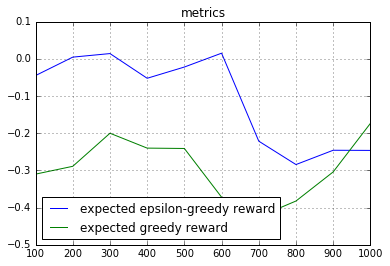

epoch 1100, mse 9.23631, epsilon 0.66183, rewards: ( e-greedy -0.36164, greedy -0.35630) 
epoch 1200, mse 12.02901, epsilon 0.63784, rewards: ( e-greedy -0.44547, greedy -0.36067) 
epoch 1300, mse 11.53297, epsilon 0.61479, rewards: ( e-greedy -0.31093, greedy 0.01540) 
epoch 1400, mse 12.83227, epsilon 0.59265, rewards: ( e-greedy -0.33483, greedy 0.11386) 
epoch 1500, mse 15.72716, epsilon 0.57137, rewards: ( e-greedy -0.37135, greedy 0.22247) 
epoch 1600, mse 10.68375, epsilon 0.55093, rewards: ( e-greedy -0.27921, greedy 0.28023) 
epoch 1700, mse 6.49275, epsilon 0.53129, rewards: ( e-greedy -0.11629, greedy 0.51220) 
epoch 1800, mse 10.15133, epsilon 0.51241, rewards: ( e-greedy -0.14466, greedy 0.70098) 
epoch 1900, mse 8.88154, epsilon 0.49428, rewards: ( e-greedy 0.08480, greedy 1.01089) 
epoch 2000, mse 6.80289, epsilon 0.47686, rewards: ( e-greedy 0.19632, greedy 1.14980) 
Learning curves:


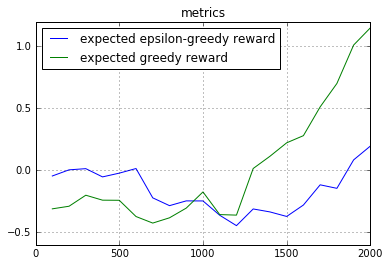

epoch 2100, mse 6.37208, epsilon 0.46012, rewards: ( e-greedy 0.27669, greedy 1.29482) 
epoch 2200, mse 12.12648, epsilon 0.44404, rewards: ( e-greedy 0.24402, greedy 1.39034) 
epoch 2300, mse 3.74050, epsilon 0.42859, rewards: ( e-greedy 0.36462, greedy 1.53130) 
epoch 2400, mse 7.10532, epsilon 0.41375, rewards: ( e-greedy 0.50816, greedy 1.69817) 
epoch 2500, mse 10.95141, epsilon 0.39949, rewards: ( e-greedy 0.49234, greedy 1.82835) 
epoch 2600, mse 6.96907, epsilon 0.38578, rewards: ( e-greedy 0.42811, greedy 1.96552) 
epoch 2700, mse 5.64347, epsilon 0.37262, rewards: ( e-greedy 0.53030, greedy 2.06897) 
epoch 2800, mse 7.56950, epsilon 0.35997, rewards: ( e-greedy 0.43227, greedy 2.13207) 
epoch 2900, mse 5.00188, epsilon 0.34781, rewards: ( e-greedy 0.51404, greedy 2.21886) 
epoch 3000, mse 2.44909, epsilon 0.33613, rewards: ( e-greedy 0.68764, greedy 2.31698) 
Learning curves:


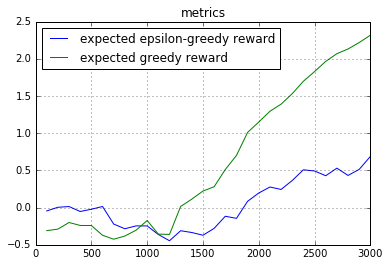

epoch 3100, mse 5.78912, epsilon 0.32492, rewards: ( e-greedy 0.77387, greedy 2.36528) 
epoch 3200, mse 5.30970, epsilon 0.31414, rewards: ( e-greedy 0.79149, greedy 2.37875) 
epoch 3300, mse 1.79242, epsilon 0.30378, rewards: ( e-greedy 0.88734, greedy 2.42088) 
epoch 3400, mse 5.31371, epsilon 0.29383, rewards: ( e-greedy 0.89360, greedy 2.42879) 
epoch 3500, mse 7.62451, epsilon 0.28427, rewards: ( e-greedy 0.94924, greedy 2.50591) 
epoch 3600, mse 4.24730, epsilon 0.27508, rewards: ( e-greedy 1.07932, greedy 2.49532) 
epoch 3700, mse 6.74200, epsilon 0.26626, rewards: ( e-greedy 1.19639, greedy 2.48579) 
epoch 3800, mse 4.25607, epsilon 0.25778, rewards: ( e-greedy 1.21675, greedy 2.47721) 
epoch 3900, mse 4.80278, epsilon 0.24963, rewards: ( e-greedy 1.18007, greedy 2.50949) 
epoch 4000, mse 8.11864, epsilon 0.24180, rewards: ( e-greedy 1.21707, greedy 2.53854) 
Learning curves:


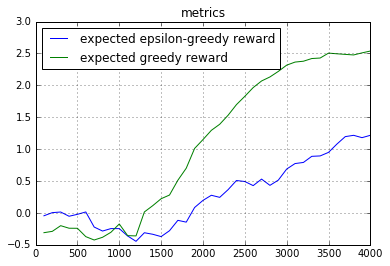

epoch 4100, mse 2.80476, epsilon 0.23428, rewards: ( e-greedy 1.32036, greedy 2.56468) 
epoch 4200, mse 1.60868, epsilon 0.22706, rewards: ( e-greedy 1.49832, greedy 2.66822) 
epoch 4300, mse 1.54942, epsilon 0.22011, rewards: ( e-greedy 1.50349, greedy 2.66139) 
epoch 4400, mse 2.87758, epsilon 0.21344, rewards: ( e-greedy 1.64814, greedy 2.70026) 
epoch 4500, mse 5.89048, epsilon 0.20703, rewards: ( e-greedy 1.61833, greedy 2.67023) 
epoch 4600, mse 5.68254, epsilon 0.20088, rewards: ( e-greedy 1.63649, greedy 2.64321) 
epoch 4700, mse 3.29212, epsilon 0.19496, rewards: ( e-greedy 1.72785, greedy 2.68889) 
epoch 4800, mse 4.33449, epsilon 0.18928, rewards: ( e-greedy 1.72506, greedy 2.70000) 
epoch 4900, mse 4.00894, epsilon 0.18382, rewards: ( e-greedy 1.70755, greedy 2.69000) 
epoch 5000, mse 3.67681, epsilon 0.17857, rewards: ( e-greedy 1.69680, greedy 2.61100) 
Learning curves:


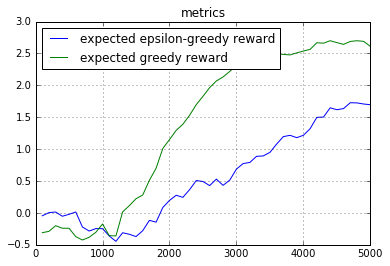

In [15]:
n_epochs = 5000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
    resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print("epoch %i, mse %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))

        
    #visualize learning curve and sample sessions
    if epoch_counter %1000 ==0:
        print("Learning curves:")
        score_log.plot()
        
    epoch_counter  +=1


# Evaluate results

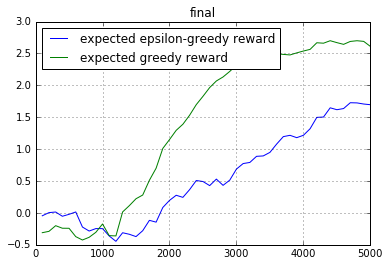

In [16]:
score_log.plot("final")

In [17]:
#convergence test
scores = [score_log["expected greedy reward"][i] 
          for i in sorted(list(score_log["expected greedy reward"]))
         ]
assert max(scores[-5:]) > 2.5

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [18]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

Random session examples
session # 0
 X1(qv = 2.76887083054) -> -1.0 |  Y2(qv = 2.8640999794) -> 3.0 |  X1(qv = -0.00434866175056) -> -0.5 |  X1(qv = 0.0688417106867) -> -0.5 |  Y2(qv = 0.182224422693) -> -0.5 |  End_session_now(qv = -0.00804406777024) -> 0.0 | 



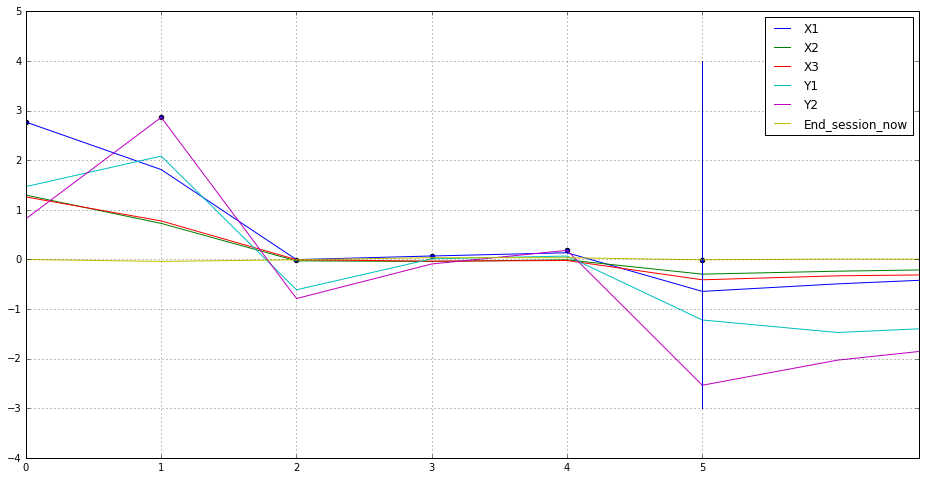

session # 1
 X1(qv = 2.76887083054) -> -1.0 |  Y2(qv = 2.8640999794) -> 3.0 |  X1(qv = -0.00434866175056) -> -0.5 |  X1(qv = 0.0688417106867) -> -0.5 |  Y2(qv = 0.182224422693) -> -0.5 |  End_session_now(qv = -0.00804406777024) -> 0.0 | 



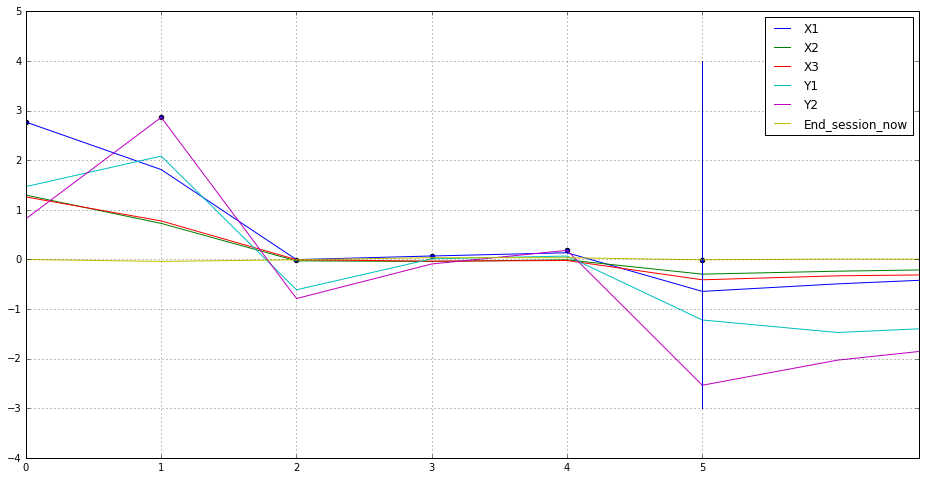

session # 2
 X1(qv = 2.76887083054) -> 1.0 |  Y1(qv = 2.92296528816) -> 3.0 |  End_session_now(qv = -0.0097652412951) -> 0.0 | 



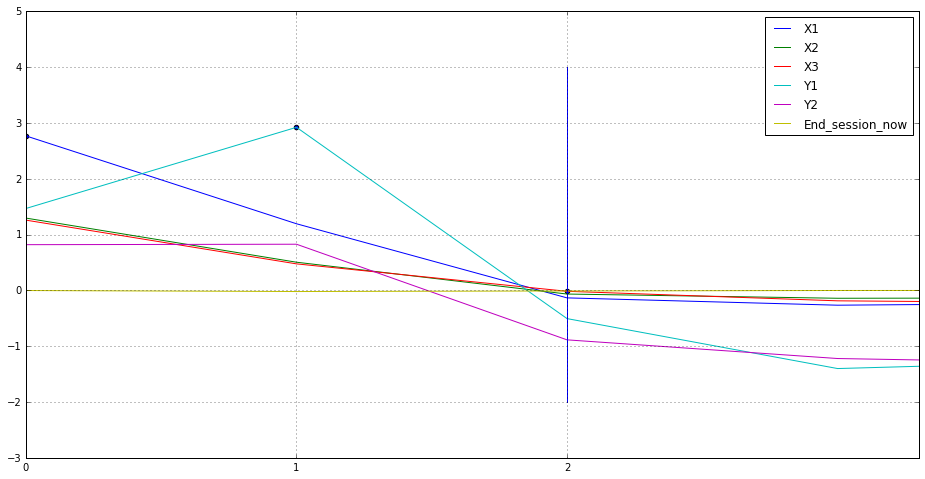

session # 3
 X1(qv = 2.76887083054) -> 1.0 |  Y1(qv = 2.92296528816) -> 3.0 |  End_session_now(qv = -0.0097652412951) -> 0.0 | 



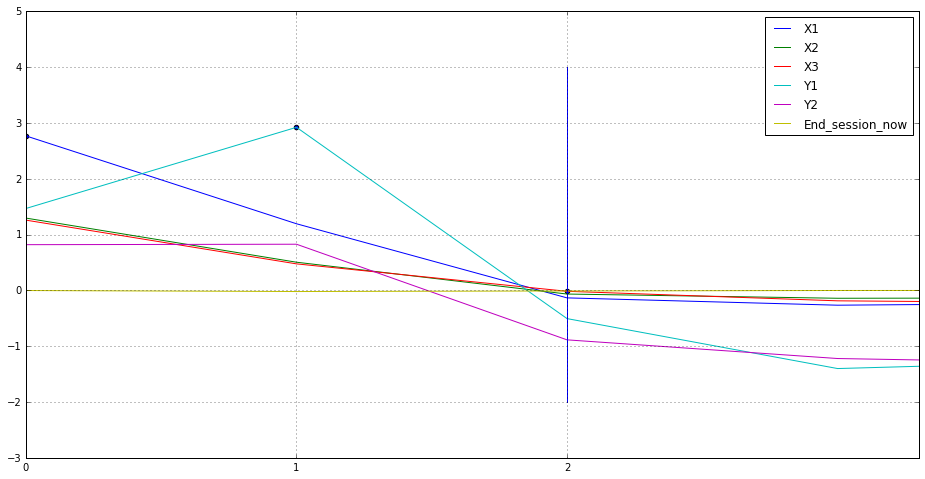

session # 4
 X1(qv = 2.76887154579) -> 1.0 |  Y1(qv = 2.92296457291) -> 3.0 |  End_session_now(qv = -0.00976521149278) -> 0.0 | 



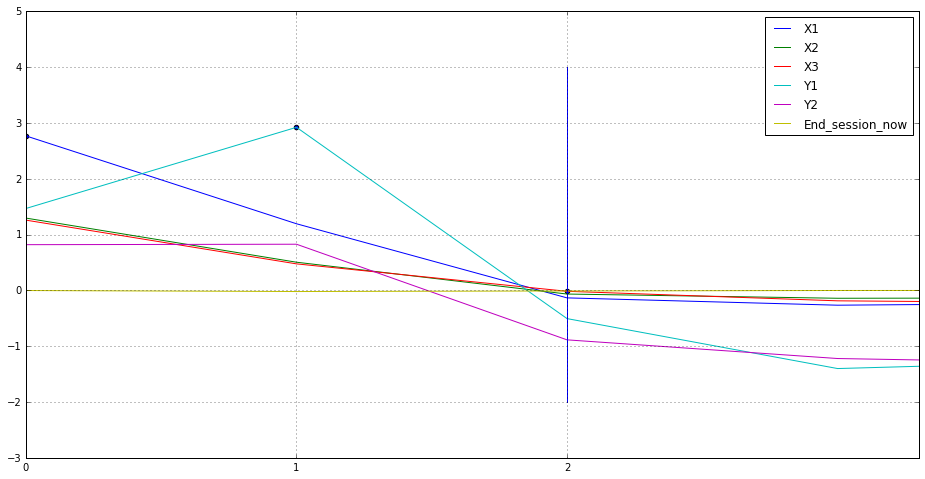

In [19]:
resolver.epsilon.set_value(np.float32(0.))
print("Random session examples")
env.generate_new_data_batch(5)
display_sessions(with_plots=True)
